# Load data set and first data exploration

In [1]:
# First:
# take a look at the data
# get an overview
#
# Second:
# try out basic model - check
#
# Third:
# Improve it - check
# get ideas to make it better
# use different features for production and generation
# compare the rmses
# compare with basic benchmark -> E2E
# generate more data to make it better
# include P in load forecast
# add a "daily Maximum" to get the peaks
#
#
# prepare repo
#

#
# normalize the target variable
# use resample to hourly?
# get public holidays
# LGBM regressor
# just throw a fancy model on it
# Hyperparameter tuning


In [2]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import holidays
from datetime import date

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#test.head()
sample_submission = pd.read_csv('sample_submission.csv')

len(train)

88712

Residual_load = load - P
 residual load positive means it needs more than it produces

# Time manipulations

In [4]:
# convert to date time
train['datetime'] = pd.to_datetime(train.time, infer_datetime_format=True)
test['datetime'] = pd.to_datetime(test.time, infer_datetime_format=True)


train.set_index('datetime', inplace=True)
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month

test.set_index('datetime', inplace=True)
test['hour'] = test.index.hour
test['day'] = test.index.day
test['month'] = test.index.month


## check weather its a weekday or a weekend
train['weekday'] = train.index.weekday
test['weekday'] = test.index.weekday
train['weekday'] = train['weekday'].apply(lambda x: 1 if x <= 4 else 0)
test['weekday'] = test['weekday'].apply(lambda x: 1 if x <= 4 else 0)

# train.weekday.value_counts()
# monday is 0
# sunday = 6

### Holidays

hessen_holidays = holidays.country_holidays('DE', subdiv='HE')

# date(2015, 1, 1) in hessen_holidays  # True
# date(2015, 1, 2) in hessen_holidays  # False
# train.index[0] in hessen_holidays

time = train.index.copy()
holidayOrNot = []
for itime in time:
    holidayOrNot.append(itime in hessen_holidays)

train['public_holidays'] = holidayOrNot
train['public_holidays'] = train['public_holidays'].apply(lambda x: 1 if x == True else 0)

## do the same for test
time = test.index.copy()
holidayOrNot = []
for itime in time:
    holidayOrNot.append(itime in hessen_holidays)

test['public_holidays'] = holidayOrNot
test['public_holidays'] = test['public_holidays'].apply(lambda x: 1 if x == True else 0)

In [7]:
train.datetime.iloc[0]

AttributeError: 'DataFrame' object has no attribute 'datetime'

In [10]:
(train.index[-1]-train.index[0]).days/365

2.7753424657534245

In [4]:
## Convert Time Features to Sinosoids and Cosine
time = train.index.copy()
dayOfYearCos = []
dayOfYearSin = []
doy = []
for itime in time:
    doy.append(itime.timetuple().tm_yday)
    dayOfYearCos.append(np.cos(itime.timetuple().tm_yday/365*2*np.pi))
    dayOfYearSin.append(np.sin(itime.timetuple().tm_yday/365*2*np.pi))

train['dayOfYearSinosoid'] = dayOfYearSin
train['dayOfYearCosine'] = dayOfYearCos
train['monthSinosoid'] = np.sin(train['month']/12*2*np.pi)
train['monthCosine'] = np.cos(train['month']/12*2*np.pi)
train['hourSinosoid'] = np.sin(train['hour']/24*2*np.pi)
train['hourCosine'] = np.cos(train['hour']/24*2*np.pi)


## Same for Test
time = test.index.copy()
dayOfYear = []
for itime in time:
    dayOfYearCos.append(np.cos(itime.timetuple().tm_yday/365*2*np.pi))
    dayOfYearSin.append(np.sin(itime.timetuple().tm_yday/365*2*np.pi))

train['dayOfYearSinosoid'] = dayOfYearSin
train['dayOfYearCosine'] = dayOfYearCos
train['monthSinosoid'] = np.sin(train['month']/12*2*np.pi)
train['monthCosine'] = np.cos(train['month']/12*2*np.pi)
train['hourSinosoid'] = np.sin(train['hour']/24*2*np.pi)
train['hourCosine'] = np.cos(train['hour']/24*2*np.pi)



In [ ]:
plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.month, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('month')
plt.savefig('figs/residual_load_per_month.png')

plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.weekday, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('weekday')

plt.savefig('figs/residual_load_per_weekday.png')

plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.hour, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('hour')

plt.savefig('figs/residual_load_per_hour.png')

In [117]:
train.head()


,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id,hour,day,month
datetime,,,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,113.5,113.5,1,0,1,1
2018-01-01 00:15:00,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,119.0,119.0,1,0,1,1
2018-01-01 00:30:00,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,117.5,117.5,1,0,1,1
2018-01-01 00:45:00,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,114.5,114.5,1,0,1,1
2018-01-01 01:00:00,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,123.0,123.0,1,1,1,1


In [3]:
test.head()

,time,Gb(i),Gd(i),H_sun,T2m,WS10m,dataset_id
0,2018-03-26 00:00:00,0.0,0.0,0.0,1.76,1.52,1
1,2018-03-26 00:15:00,0.0,0.0,0.0,1.57,1.52,1
2,2018-03-26 00:30:00,0.0,0.0,0.0,1.38,1.52,1
3,2018-03-26 00:45:00,0.0,0.0,0.0,1.19,1.52,1
4,2018-03-26 01:00:00,0.0,0.0,0.0,1.00,1.52,1


In [4]:
# Data Cleaning / Feture Generation

# three models:
# 1. predict load
# use 11 prediction models

# 2. predict generation and calculate

# ignore/leave out load and generation
# # e2e forecast -> directly predict residual load

In [ ]:
# What is the time period of each dataset?

# How are the dataset_ids distributed?
# All dataset Ids are equally distributed, between the train dataset IDs! see figure (train_and_test_time_datasetid_separation.png)
# Train 8068 samples for each id
# Test has 672 samples for each id

# 83 days of train data
# 6 days of test data

# Are they significantly different
# Cluster analysis of 5 features?

In [53]:
# train['dataset_id'].value_counts()
# test['dataset_id'].value_counts()
# test['dataset_id'].value_counts()

In [ ]:
# use random samples from each dataset id to evaluate it
# 1. without date features
# 2. with date features
# add generation and load
#
# 3. train for dataset combinations
# 4. use the right model for the right data set -> map id to model
# 5. predict and generate sample_submission

# split the train data in train and validate

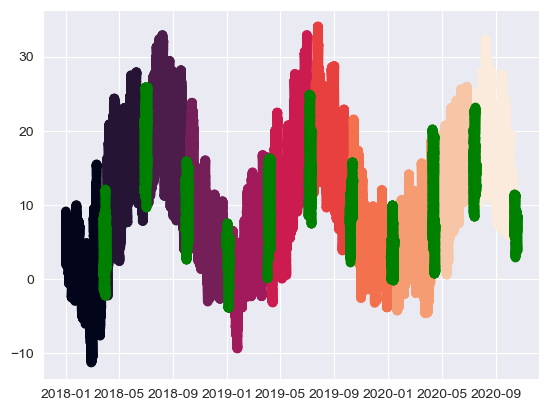

In [54]:

# plt.scatter(train.time,train.residual_load,c=train.dataset_id)
#plt.subplot(1,2,1)
plt.scatter(train.datetime,train['T2m'],c=train['dataset_id'])
#plt.subplot(1,2,2)
plt.scatter(test.datetime,test['T2m'],c='green')

# mixed model
# test dataset id is directly between two data sets!
# find out if ids are matching
#
# if test is id1, same period as id1 and id2 in train?
# train a mixture of models!
#plt.savefig('figs/train_and_test_time_datasetid_separation.png')
plt.show()

In [ ]:
# maybe group two dataset Ids together
# or group by month in year
# -> get similarity of weather featuers + dataset_id
plt.scatter(train.index,train.dataset_id)
plt.scatter(test.index,test.dataset_id)

Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0
Len of test days 6.0


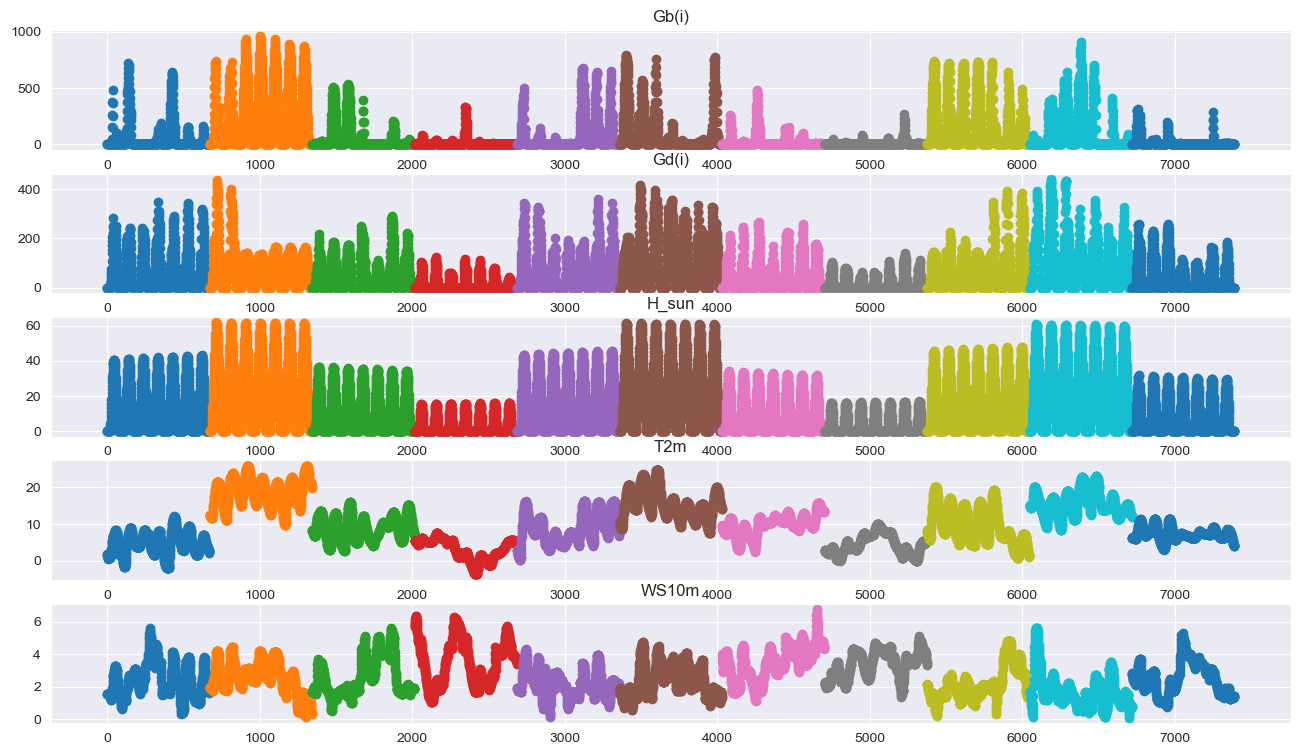

In [47]:
uniqueIds = np.unique(test['dataset_id'])

# 83 days of train data
# 6 days of test data
metVars = ['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']
# uniqueIds
# sel_id = 1
plt.figure(figsize=(16,9))
for sel_id in uniqueIds:
    selectTestDf = test.loc[test['dataset_id']==sel_id]
    count = 1
    for ivar in metVars:
        plt.subplot(len(metVars),1,count)
        count +=1
        plt.scatter(selectTestDf.index,selectTestDf[ivar])
        plt.title(ivar)
    testDuration = (selectTestDf['datetime'].values[-1]-selectTestDf['datetime'].values[0]).astype('timedelta64[D]')/( np.timedelta64(1, 'D'))

    print('Len of test days', testDuration)

#plt.savefig('figs/num_train_days.png')
plt.savefig('figs/num_test_days.png')


# Feature generation

In [ ]:
## FIRST GET THE AVERAGE CURVE FOR WEEKDAYS AND OTHER DAYS
def get_avg_day_load(df):
    # average weekend curve
    # average week curve

    # reshape it into days and
    dayShapedLoad = np.reshape(df.load.values[:88704],(-1,96))
    dayShapedWeekday = np.reshape(df.weekday.values[:88704],(-1,96))
    dayShapedHoliday = np.reshape(df.public_holidays.values[:88704],(-1,96))


    weekDayLoad = np.empty((1,96))
    otherDayLoad = np.empty((1,96))

    for i in range(0,len(dayShapedLoad)):
#         if (np.unique(dayShapedHoliday[i])==1) or (np.unique(dayShapedWeekday[i])==0):
        if (round(np.mean(dayShapedHoliday[i]))==1) or (round(np.mean(dayShapedWeekday[i]))==0):
#            print('holiday or weekend')
            otherDayLoad = np.vstack((otherDayLoad,np.reshape(dayShape[i],(1,96))))
        else:
            weekDayLoad = np.vstack((weekDayLoad,np.reshape(dayShape[i],(1,96))))

    weekDayLoad = weekDayLoad[1:]
    otherDayLoad = otherDayLoad[1:]

    weekDayModel_avg  = np.mean(weekDayLoad,axis=0)
    weekDayModel_std  = np.std(weekDayLoad,axis=0)

    otherModel_avg  = np.mean(otherDayLoad,axis=0)
    otherModel_std  = np.std(otherDayLoad,axis=0)


    return weekDayModel_avg, weekDayModel_std, otherModel_avg, otherModel_std

## THEN GENERATE A VECTOR FROM TIME INDEX
def generate_avg_model(df,weekModel_avg,otherModel_avg, weekModel_std,otherModel_std,hourInddict):

    avg_model = []
    std_model = []

    for i in range(len(df)):
        if (np.unique(df.public_holidays[i])==1) or (np.unique(df.weekday[i])==0):
            use_index = hourInddict[df.index[i].hour][df.index[i].minute]

            avg_model.append(otherModel_avg[use_index])
            std_model.append(otherModel_std[use_index])
        else:
            use_index = hourInddict[df.index[i].hour][df.index[i].minute]

            avg_model.append(weekDayModel_avg[use_index])
            std_model.append(weekDayModel_std[use_index])

    return avg_model, std_model


## STEP 1
weekDayModel_avg, weekDayModel_std, otherModel_avg, otherModel_std = get_avg_day_load(train)


## STEP 2
## first create the dict within dict
hourInddict = dict()
for ind in range(96):

    hourInddict[train.index[ind].hour] = dict()

# then fill it with the 96 values
for ind in range(96):
    hourInddict[train.index[ind].hour][train.index[ind].minute] = ind

avg_model_train, std_model = generate_avg_model(train,weekDayModel_avg,otherModel_avg, weekDayModel_std,otherModel_std, hourInddict)
avg_model_test, std_model = generate_avg_model(test,weekDayModel_avg,otherModel_avg, weekDayModel_std,otherModel_std, hourInddict)

####

## ADD TO TRAIN AND TEST
train['avg_load_model'] = avg_model_train
test['avg_load_model'] = avg_model_test

plt.plot(avg_model_train[0:800], alpha=0.2)

train.head()

In [ ]:
# reshape the weekday
# reshape the public_holiday

# go through days
# check if weekday

plt.subplot(1,2,1)
plt.plot(weekDayLoad.T,alpha=0.05)
plt.plot(np.mean(weekDayLoad,axis=0),color='black',label='avg')
plt.plot(np.mean(weekDayLoad,axis=0)-np.std(weekDayLoad,axis=0),color='black',linestyle='dashed', label='std')
plt.plot(np.mean(weekDayLoad,axis=0)+np.std(weekDayLoad,axis=0),color='black',linestyle='dashed')
plt.title('Week Day Load')
plt.legend()

plt.subplot(1,2,2)
plt.plot(otherDayLoad.T,alpha=0.05)
plt.plot(np.mean(otherDayLoad,axis=0),color='black',label='avg')
plt.plot(np.mean(otherDayLoad,axis=0)-np.std(otherDayLoad,axis=0),color='black',linestyle='dashed', label='std')
plt.plot(np.mean(otherDayLoad,axis=0)+np.std(otherDayLoad,axis=0),color='black',linestyle='dashed')
plt.title('Other Day Load')

plt.suptitle('average load model')
plt.legend()

plt.savefig('figs/generate_average_load_model.png')

# return a matrix depending on the timestring
# return avg + std

# Outlier removal

C:\Users\ghein\AppData\Local\Temp\ipykernel_21072\2981082562.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.load[idx_outliers] = np.min(train.load[idx])


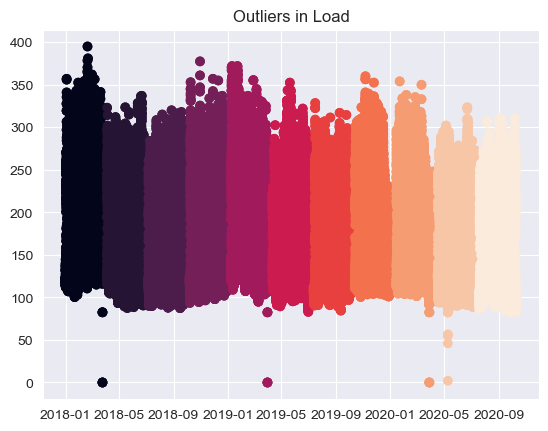

In [5]:
## Outlier analysis
# 4 times wher load drops down to zero

plt.scatter(train.index,train.load,c=train.dataset_id)
# num outliers?
plt.title('Outliers in Load')
# its just 16 values
# set those values to the minimum in the
plt.savefig('figs/outliers_in_the_load.png')

outlier_tresh = 82
replace_with = 'min'
idx = np.where(train.load>outlier_tresh)[0]
idx_outliers = np.where(train.load<=outlier_tresh)[0]

if replace_with == 'min':
    train.load[idx_outliers] = np.min(train.load[idx])

# after filtering the outliers out
plt.scatter(train.index,train.load,c=train.dataset_id)

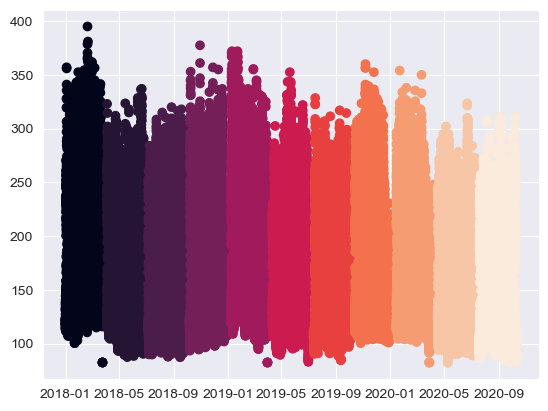

In [6]:
plt.scatter(train.index,train.load,c=train.dataset_id)

# NORMALIZATION

[[ 0.02328831]
 [ 0.07452259]
 [ 0.0605496 ]
 ...
 [-0.0978109 ]
 [-0.12575687]
 [-0.07918025]]
[[113.5]
 [119. ]
 [117.5]
 ...
 [100.5]
 [ 97.5]
 [102.5]]


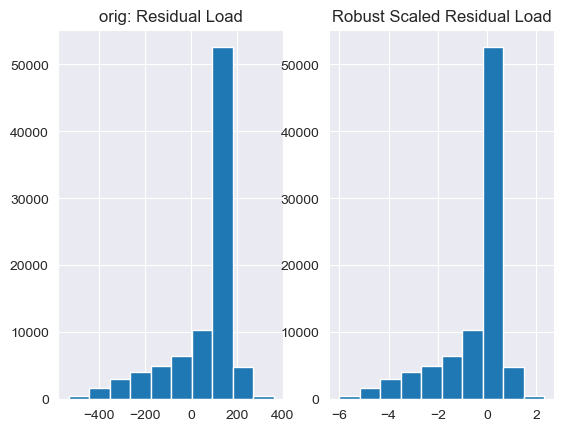

In [8]:
# Noramlized Residual Load - transformer1
# Normalized the Load - transformer2
# Forecast of P was ok, did not normalize it (yet)

# normalize it first and use XTrans for prediction
# add a normalized_residual_load column
from sklearn.preprocessing import RobustScaler
Y = train.residual_load.values.copy()

Y = np.reshape(Y, (len(Y),-1))

transformer1 = RobustScaler().fit(Y)

YTrans = transformer1.transform(Y)
train['normalized_residual_load'] = YTrans
print(YTrans)

## TRANSFORM ALSO THE TEST DATA
YiTrans = transformer1.inverse_transform(YTrans)

print(YiTrans)

plt.subplot(1,2,1)
plt.hist(train.residual_load)
plt.title('orig: Residual Load')

plt.subplot(1,2,2)
# is this large imbalance a problem?
plt.hist(YTrans)
plt.title('Robust Scaled Residual Load')

plt.savefig('figs/target_residual_load_scaled.png')

In [329]:
# tried it also with quantile transformers, but Robust Scaler is better!

# from sklearn.preprocessing import QuantileTransformer
#qt = QuantileTransformer(n_quantiles=500, output_distribution="normal", random_state=rng).fit(Y)
#YTrans = qt.transform(Y)

## TRANSFORM LOAD VALUES
rng = np.random.RandomState(304)
Y = train.load.values
Y = np.reshape(Y, (len(Y),-1))

transformer2 = RobustScaler().fit(Y)
load_transformed_train = transformer2.transform(Y)

train['normalized_load'] = load_transformed_train

# Test Data does not have load to transform, but the predicted has to be transformed
# ## TRANSFORM ALSO TEST DATA

##############################
## ALSO TRANSFORM THE PRODUCTION
rng = np.random.RandomState(304)
Y2 = train.P.values
Y2 = np.reshape(Y2, (len(Y2),-1))
transformer3 = RobustScaler().fit(Y2)

P_transformed_train = transformer3.transform(Y2)

train['normalized_P'] = P_transformed_train



In [110]:
np.mean(Y)

52.002035463071515

In [ ]:
plt.hist(train.load,bins=50)

# PREDICTION

In [145]:
train.head()

,time,P,Gb(i),Gd(i),H_sun,T2m,WS10m,load,residual_load,dataset_id,hour,day,month,greaterThanThreshold,normalized_residual_load
datetime,,,,,,,,,,,,,,,
2018-01-01 00:00:00,2018-01-01 00:00:00,0.0,0.0,0.0,0.0,9.11,5.38,113.5,113.5,1,0,1,1,1,0.023288
2018-01-01 00:15:00,2018-01-01 00:15:00,0.0,0.0,0.0,0.0,8.89,5.43,119.0,119.0,1,0,1,1,1,0.074523
2018-01-01 00:30:00,2018-01-01 00:30:00,0.0,0.0,0.0,0.0,8.66,5.48,117.5,117.5,1,0,1,1,1,0.060550
2018-01-01 00:45:00,2018-01-01 00:45:00,0.0,0.0,0.0,0.0,8.44,5.54,114.5,114.5,1,0,1,1,1,0.032604
2018-01-01 01:00:00,2018-01-01 01:00:00,0.0,0.0,0.0,0.0,8.22,5.59,123.0,123.0,1,1,1,1,1,0.111784


# 1. PREDICT THE LOAD

In [334]:
# make the training as a function for multiple regression models

def train_a_gbrt_model(df,features,target):
    X = df[features].to_numpy()
    y = df[target].to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), random_state=0)
    # more estimators is better
    # max_depth -> better
    # step_size -> greater is better
    # params = { "n_estimators": 500,"max_depth": 4, "min_samples_split": 5, "learning_rate": 0.01,"loss": "squared_error"} # orig config
    # params = { "n_estimators": 500,"max_depth": 5, "min_samples_split": 5, "learning_rate": 0.01,"loss": "squared_error"} # better
    params = { "n_estimators": 1000,"max_depth": 5, "min_samples_split": 5, "learning_rate": 0.02,"loss": "squared_error"} # better
    reg_model = GradientBoostingRegressor(**params)

    reg_model.fit(X_train, y_train)

    return reg_model, X_train, X_test, y_train, y_test


uniqueIds = np.unique(test['dataset_id'])

## PREDICT THE LOAD
metVars = ['Gb(i)', 'Gd(i)', 'H_sun', 'T2m', 'WS10m']
# timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid']
timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid', 'weekday', 'public_holidays']
# features = metVars
# features = metVars+timeVars
# features = metVars+timeVars +['P'] # include P in the load forecast

features = metVars+timeVars +['avg_load_model'] # an average load model

# target = 'residual_load'
# target = 'normalized_residual_load'
# target = 'P'
# target = 'load'
target = 'normalized_load'

individual_models = []
load_models ={} # a dictionary to collect the individual models
sel_id = 1
#for sel_id in uniqueIds[0:5]:
for sel_id in uniqueIds:
    # train_part1 = train.loc[(train['hour'] >= 5) | (train['hour'] <= 16 )] # predict the night load
    train_part = train.loc[train['dataset_id']==sel_id]

    # reg_model, X_train, X_test, y_train, y_test = train_a_gbrt_model(train_part1,features,target)
    reg_model, X_train, X_val, y_train, y_val = train_a_gbrt_model(train_part,features,target)
    load_models['dataset_id_{}'.format(sel_id)] = reg_model

    print(reg_model.score(X_val, y_val))
    individual_models.append(reg_model.score(X_val, y_val))

# collect the scores and take a weighted average, depending on the number of

0.9597220156232855
0.9579794721513408
0.9552057921504437
0.9654596570587386
0.9567058867196699
0.9581842249755076
0.9474323024514544
0.9510632186963289
0.9596255651588312
0.9610114078026433
0.9490188352374227


In [ ]:
# 0.9597220156232855
# 0.9579794721513408
# 0.9552057921504437
# 0.9654596570587386
# 0.9567058867196699
# 0.9581842249755076
# 0.9474323024514544
# 0.9510632186963289
# 0.9596255651588312

In [313]:
# Simple full load prediction
# reg_model, X_train, X_test, y_train, y_test = train_a_gbrt_model(train_part1,features,target)
reg_model, X_train, X_val, y_train, y_val = train_a_gbrt_model(train,features,target)
# load_models['dataset_id_{}'.format(sel_id)] = reg_model

print(reg_model.score(X_val, y_val))
# is worse than individual - 0.883324115572189

0.883324115572189


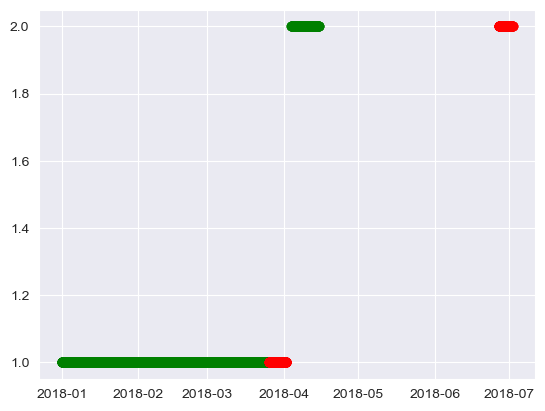

In [310]:
plt.scatter(train.index[0:96*95],train.dataset_id[0:96*95], color='green')
plt.scatter(test.index[0:1200],test.dataset_id[0:1200],color='red')

# first make a prediction with the model that it has the same id with
# then make a prediction with the model it is neighboring

# using a higher

In [13]:
# np.mean(individual_models)

# use the residual from this prediction to calculate
# 0.9019288364891463
# WITH average Load model at
# 0.9321167726692882

0.9019288364891463

0.9564916707296061


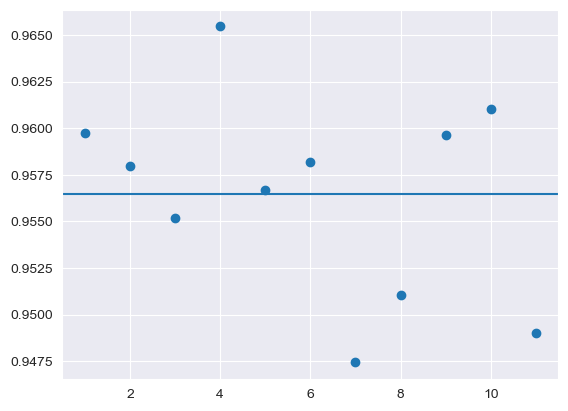

In [335]:
plt.scatter(uniqueIds,individual_models)
plt.axhline(np.mean(individual_models))
print(np.mean(individual_models))
# Prediction of individual Dataset, Target different size:
# Production Accuracy at 93 %
# Generation Accuracy at 73 % -> 89 % after adding weekdays 0/1


# Production forecast is good
# Load Forecast is ok with weekdays
# How to improve that?
# Add Holidays

In [311]:
uniqueIds

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

In [355]:
def make_load_predictions(df, load_models,datasetIds,useModelIds):

    times = []
    predicted_nload_train = []
    for dataId in range(len(datasetIds)):
    #    print(dataId)
    #     print('datasetId', datasetIds[dataId])
    #     print('using Model ', useModelIds[dataId])
        df_part = df.loc[df['dataset_id']==datasetIds[dataId]]

        X = df_part[features].to_numpy()
        # you can choose a different foreacasting model
        reg_model = load_models['dataset_id_{}'.format(useModelIds[dataId])]

        times.append(df_part.index)
        predicted_nload_train.append(reg_model.predict(X))

    # concat predictions
    predicted_normalized_load = np.array(0)
    for i in range(len(predicted_nload_train)):
        predicted_normalized_load = np.append(predicted_normalized_load,predicted_nload_train[i])

    # remove the first entry amd compare with actual load
    predicted_normalized_load = predicted_normalized_load[1:]


    return predicted_normalized_load

predicted_normalized_load_train = make_load_predictions(train, load_models,uniqueIds,uniqueIds)
# Just shift the used model by 1, because the test data is on the border
predicted_normalized_load_train_alt = make_load_predictions(train, load_models,uniqueIds,np.roll(uniqueIds,-1))

mean_pred_normalized_load_train = np.mean([predicted_normalized_load_train, predicted_normalized_load_train_alt],axis=0)

predicted_normalized_load_test = make_load_predictions(test, load_models,uniqueIds,uniqueIds)
predicted_normalized_load_test_alt = make_load_predictions(test, load_models,uniqueIds,np.roll(uniqueIds,-1))

mean_pred_normalized_load_test = np.mean([predicted_normalized_load_test, predicted_normalized_load_test_alt],axis=0)

print(len(predicted_normalized_load_train),len(predicted_normalized_load_test))


datasetId 1
using Model  1
datasetId 2
using Model  2
datasetId 3
using Model  3
datasetId 4
using Model  4
datasetId 5
using Model  5
datasetId 6
using Model  6
datasetId 7
using Model  7
datasetId 8
using Model  8
datasetId 9
using Model  9
datasetId 10
using Model  10
datasetId 11
using Model  11
datasetId 1
using Model  2
datasetId 2
using Model  3
datasetId 3
using Model  4
datasetId 4
using Model  5
datasetId 5
using Model  6
datasetId 6
using Model  7
datasetId 7
using Model  8
datasetId 8
using Model  9
datasetId 9
using Model  10
datasetId 10
using Model  11
datasetId 11
using Model  1
datasetId 1
using Model  1
datasetId 2
using Model  2
datasetId 3
using Model  3
datasetId 4
using Model  4
datasetId 5
using Model  5
datasetId 6
using Model  6
datasetId 7
using Model  7
datasetId 8
using Model  8
datasetId 9
using Model  9
datasetId 10
using Model  10
datasetId 11
using Model  11
datasetId 1
using Model  2
datasetId 2
using Model  3
datasetId 3
using Model  4
datasetId 4
usin

0.4043583030787945


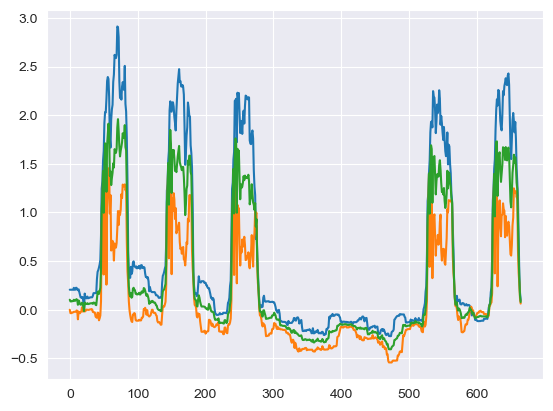

In [353]:
# window = 7*95
# index = np.random.randint(len(predicted_normalized_load_train))
#
#
# plt.plot(predicted_normalized_load_train[index:index+window])
# plt.plot(predicted_normalized_load_train_alt[index:index+window])
# plt.plot(mean_pred_normalized_load[index:index+window])
#
# print(np.mean(predicted_normalized_load_train_alt))

In [233]:

# times = []
# predicted_nload_train = []
# for dataId in uniqueIds:
# #    print(dataId)
#     train_part = train.loc[train['dataset_id']==dataId]
#
#     X = train_part[features].to_numpy()
#     reg_model = load_models['dataset_id_{}'.format(dataId)]
#
#     times.append(train_part.index)
#     predicted_nload_train.append(reg_model.predict(X))

# concat predictions
# predicted_load_train = np.array(0)
# for i in range(len(predicted_nload_train)):
#     predicted_load_train = np.append(predicted_load_train,predicted_nload_train[i])
# remove the first entry amd compare with actual load
# predicted_load_train = predicted_load_train[1:]

#
# len(predicted_load_train)

# combined = times[0].union(times[1]).union(times[3])
# len(combined)

# y_preds > predicted_nload_train
# y_pred_together > predicted_load_train
# times_train


88712

# PREDICT THE PRODUCTION

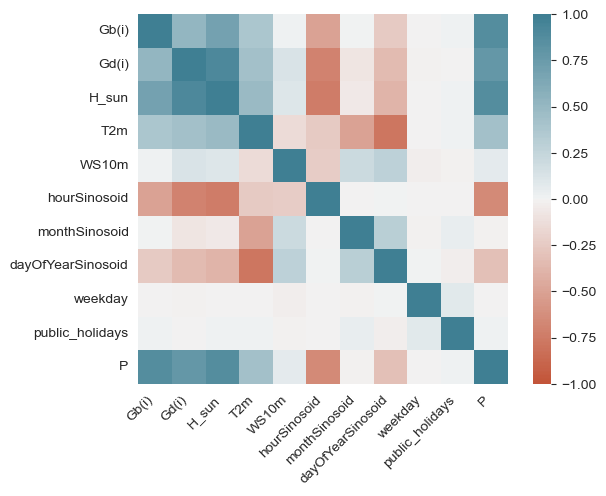

In [323]:
# normalize P as well?
# corr.P
# take out weekday and public holidays
#
corr = train[features+[target]].corr()

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [ ]:
# 1. normalize Production - check
# 2. combine forecasts - check
# Get better at predicting the production
# 3. get cloud cover from external API ?

# get additional weather features to improve prediction of P!
# need to get this in the same format


In [415]:
# features = metVars+timeVars +['P'] # take P out of the P forecast

# simple model to predict the production
# timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid', 'weekday', 'public_holidays']
timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid']
features = metVars+timeVars
# target = 'P'
target = 'normalized_P'

train_part = train.loc[train['dataset_id']==1]
# reg_model_P, X_train, X_test, y_train, y_test = train_a_gbrt_model(train,features,target)
reg_model_P, X_train, X_test, y_train, y_test = train_a_gbrt_model(train_part,features,target)

reg_model_P.predict(X_test)

print(reg_model_P.score(X_test, y_test))


# Predict Production in Train and Test set
X = train[features].to_numpy()
Xtest = test[features].to_numpy()

predicted_normalizedP_train = reg_model_P.predict(X)
predicted_normalizedP_test = reg_model_P.predict(Xtest)

0.970134446888812
0.9700922601213735


In [416]:
## ALSO SPLIT THE P PREDICTION INTO 11 MODELS
# timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid', 'weekday', 'public_holidays']
timeVars = ['hourSinosoid','monthSinosoid','dayOfYearSinosoid']
features = metVars+timeVars
# target = 'P'
target = 'normalized_P'

individual_models_P = []
p_models ={} # a dictionary to collect the individual models

#for sel_id in uniqueIds[0:5]:
for sel_id in uniqueIds:
    # train_part1 = train.loc[(train['hour'] >= 5) | (train['hour'] <= 16 )] # predict the night load
    train_part = train.loc[train['dataset_id']==sel_id]

    # reg_model, X_train, X_test, y_train, y_test = train_a_gbrt_model(train_part1,features,target)
    reg_model_P, X_train, X_val, y_train, y_val = train_a_gbrt_model(train_part,features,target)
    p_models['dataset_id_{}'.format(sel_id)] = reg_model_P

    print(reg_model_P.score(X_val, y_val))
    individual_models_P.append(reg_model_P.score(X_val, y_val))

print('avg score ', np.mean(individual_models_P))

0.9700881639351482
0.9649946292507271
0.9787777473637497
0.9698091540715723
0.9632059356154759
0.9759883901004951
0.9618186527053614
0.9354009890567045
0.9762306800557917
0.9714014513109079
0.9648726884981506


In [421]:
def make_P_predictions(df, p_models,datasetIds,useModelIds):

    times = []
    predicted_nP_train = []
    for dataId in range(len(datasetIds)):
    #    print(dataId)
    #     print('datasetId', datasetIds[dataId])
    #     print('using Model ', useModelIds[dataId])
        df_part = df.loc[df['dataset_id']==datasetIds[dataId]]

        X = df_part[features].to_numpy()
        # you can choose a different foreacasting model
        reg_model = p_models['dataset_id_{}'.format(useModelIds[dataId])]

        times.append(df_part.index)
        predicted_nP_train.append(reg_model.predict(X))

    # concat predictions
    predicted_normalized_P = np.array(0)
    for i in range(len(predicted_nP_train)):
        predicted_normalized_P = np.append(predicted_normalized_P,predicted_nP_train[i])

    # remove the first entry amd compare with actual load
    predicted_normalized_P = predicted_normalized_P[1:]


    return predicted_normalized_P

predicted_normalized_P_train = make_P_predictions(train, p_models,uniqueIds,uniqueIds)
# Just shift the used model by 1, because the test data is on the border

predicted_normalized_P_test = make_P_predictions(test, p_models,uniqueIds,uniqueIds)

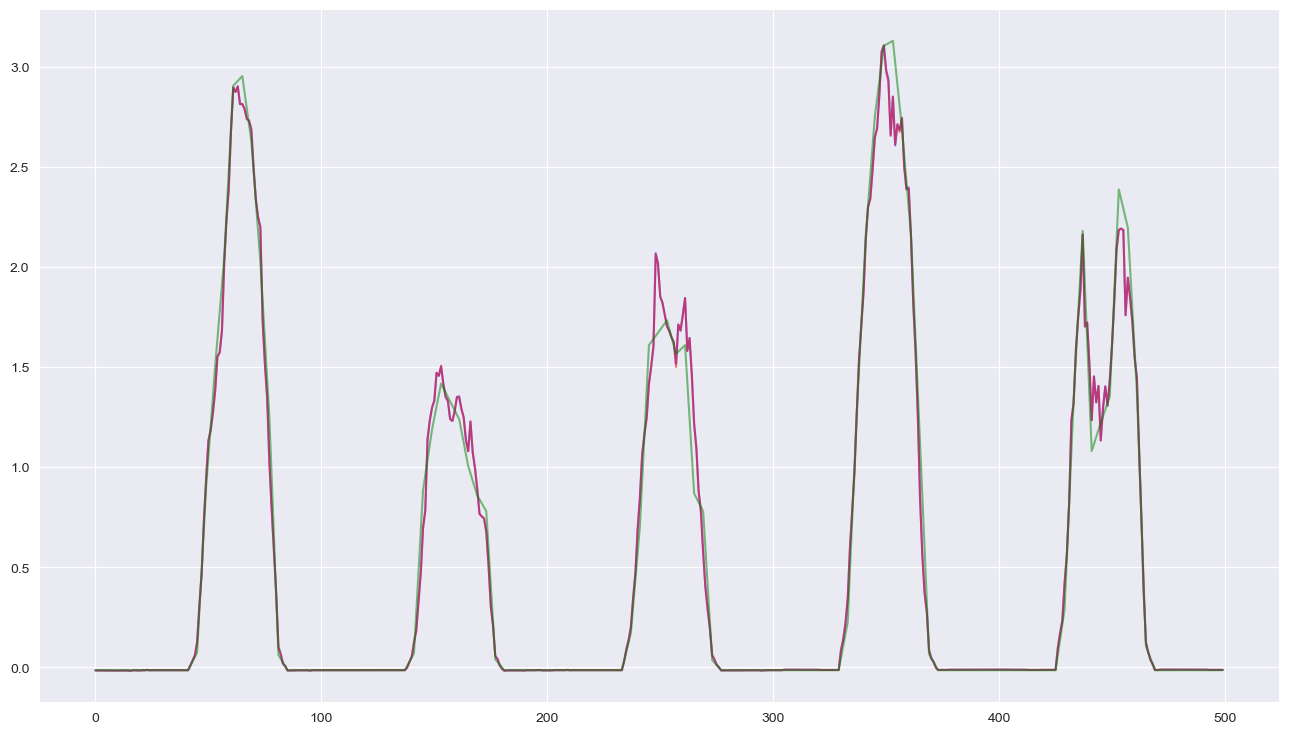

In [429]:
window = 500
index = np.random.randint(len(residual_load_test))

plt.figure(figsize=(16,9))
plt.plot(predicted_normalized_P_train[index:index+window],'b',alpha=0.5)
plt.plot(predicted_normalizedP_train[index:index+window],'r',alpha=0.5)
plt.plot(train.normalized_P.values[index:index+window],'g',alpha=0.5)



(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
 array([ 50.,  61.,  72.,  83.,  94., 105., 116., 127., 138., 149., 160.,
        171., 182., 193., 204., 215., 226., 237., 248., 259., 270., 281.,
        292., 303., 314., 325., 336., 347., 358., 369., 380., 391., 402.,
        413., 424., 435., 446., 457., 468., 479., 490., 501., 512., 523.,
        534., 545., 556., 567., 578., 589., 600.]),
 <matplotlib.collections.QuadMesh at 0x29b44897ee0>)

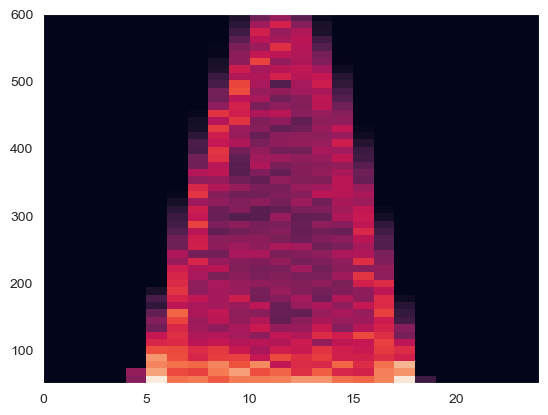

In [393]:
# plt.hist2d(train.P.values,train['Gd(i)'].values, range=[(50,400), (50,400)], bins=50)
# plt.scattera(train.hour,train.P.values, alpha=0.25, c=train['Gb(i)'])
# plt.colorbar()
# plt.hist2d(train.hour,train.P.values, range=[(0,24),(50,600) ], bins=[24,50])

In [ ]:
# Predict P - 0.9308710897211981
# Predict normalized_P - 0.9381144531087888

# create a "production" model
# daily curve scaled by the time in year
# kind of classification of "production" states - with clouds, without

In [430]:
# CALCULATE RESIDUAL LOAD

# scale load forecast back to original
# predicted_load_train = transformer2.inverse_transform(np.reshape(predicted_normalized_load_train,(-1,1)))
# predicted_load_test = transformer2.inverse_transform(np.reshape(predicted_normalized_load_test,(-1,1)))


# use the combined forecast instead the individual forecast from the dataset id
predicted_load_train = transformer2.inverse_transform(np.reshape(mean_pred_normalized_load_train,(-1,1)))
predicted_load_test = transformer2.inverse_transform(np.reshape(mean_pred_normalized_load_test,(-1,1)))


predicted_P_train = transformer3.inverse_transform(np.reshape(predicted_normalized_P_train,(-1,1)))
predicted_P_test = transformer3.inverse_transform(np.reshape(predicted_normalized_P_test,(-1,1)))

residual_load_train = predicted_load_train - np.reshape(predicted_P_train,(-1,1))
residual_load_test = predicted_load_test - np.reshape(predicted_P_test,(-1,1))


mse = mean_squared_error(train.P.values, predicted_P_train)
print("P: mean squared error (MSE) on train set: {:.4f}".format(mse))

mse = mean_squared_error(train.load.values, predicted_load_train)
print("LOAD: mean squared error (MSE) on train set: {:.4f}".format(mse))

mse = mean_squared_error(train.residual_load, residual_load_train)
print("RESIDUAL LOAD: mean squared error (MSE) on train set: {:.4f}".format(mse))

# both mse scores where good, but the Public test score was worse than before

P: mean squared error (MSE) on train set: 313.7829
LOAD: mean squared error (MSE) on train set: 312.2439
RESIDUAL LOAD: mean squared error (MSE) on train set: 628.2179


# Placeholder for best MSEs - public score is 48

In [449]:
np.shape(res_of_residual)

(88712, 1)

,Gb(i),Gd(i),H_sun,T2m,WS10m,hourSinosoid,monthSinosoid,dayOfYearSinosoid,normalized_P,res_of_res
Gb(i),1.000000,0.512513,0.688286,0.379660,0.010692,-0.501472,0.004642,-0.254491,0.874416,-0.057635
Gd(i),0.512513,1.000000,0.909203,0.431089,0.118957,-0.706048,-0.078747,-0.344463,0.779756,-0.063258
H_sun,0.688286,0.909203,1.000000,0.483897,0.108975,-0.749471,-0.057116,-0.395744,0.873075,-0.067959
T2m,0.379660,0.431089,0.483897,1.000000,-0.143108,-0.251460,-0.503401,-0.775864,0.433689,-0.215734
WS10m,0.010692,0.118957,0.108975,-0.143108,1.000000,-0.228419,0.201312,0.285797,0.067678,0.105424


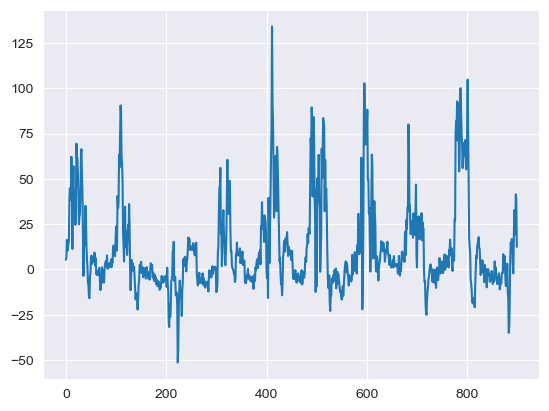

In [462]:
# first round witout the residual model
# second round with residual model?

window = 900
index = np.random.randint(len(residual_load_test))

res_of_residual = np.reshape(train.residual_load.values,(-1,1))-residual_load_train
plt.plot(res_of_residual[index:index+window])

train['res_of_res'] = res_of_residual

#sns.boxplot(x=train.dataset_id, y=np.reshape(res_of_residual,(-1,)), palette='plasma')
#plt.ylabel('Residual Load'); plt.xlabel('month')
# with which values does it correlate most
corr = train[features+[target]+['res_of_res']].corr()

corr.head()

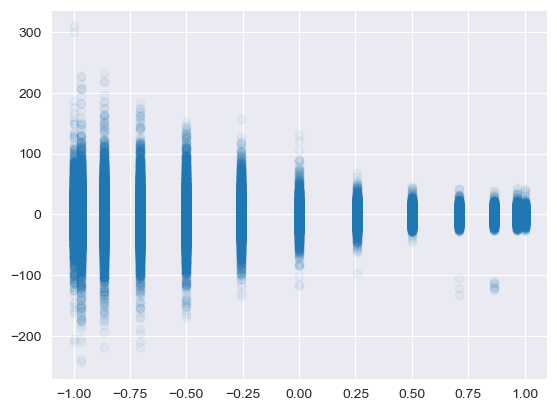

In [472]:
# plt.scatter(train.T2m.values,train.res_of_res.values,alpha=0.3)
plt.scatter(train.hourSinosoid.values,train.res_of_res.values,alpha=0.05)

# biggest errors happen, when there is most radiation and a cloud comes by

# reduce the training size -> to 75-> 60 % ? use stratification?
# generate more of the same test data

In [475]:
from sklearn.manifold import TSNE

#iris = load_iris()
#x = iris.data
#y = iris.target
# X = train[features].to_numpy()
# Xtest = test[features].to_numpy()

tsne = TSNE(n_components=2, verbose=1, random_state=123)

z = tsne.fit_transform(X)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 88712 samples in 0.249s...
[t-SNE] Computed neighbors for 88712 samples in 6.735s...
[t-SNE] Computed conditional probabilities for sample 1000 / 88712
[t-SNE] Computed conditional probabilities for sample 2000 / 88712
[t-SNE] Computed conditional probabilities for sample 3000 / 88712
[t-SNE] Computed conditional probabilities for sample 4000 / 88712
[t-SNE] Computed conditional probabilities for sample 5000 / 88712
[t-SNE] Computed conditional probabilities for sample 6000 / 88712
[t-SNE] Computed conditional probabilities for sample 7000 / 88712
[t-SNE] Computed conditional probabilities for sample 8000 / 88712
[t-SNE] Computed conditional probabilities for sample 9000 / 88712
[t-SNE] Computed conditional probabilities for sample 10000 / 88712
[t-SNE] Computed conditional probabilities for sample 11000 / 88712
[t-SNE] Computed conditional probabilities for sample 12000 / 88712
[t-SNE] Computed conditional probabilities for sam

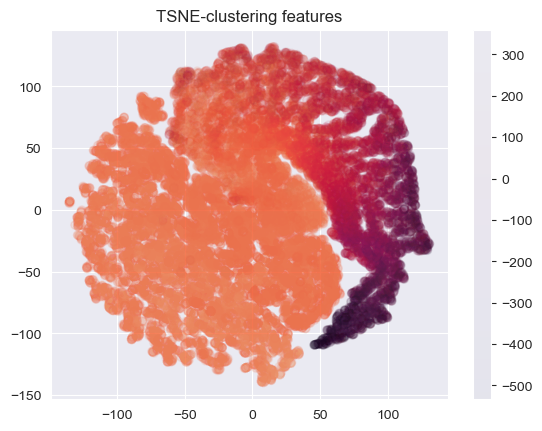

In [486]:
plt.scatter(z[:,0],z[:,1], c=train.residual_load,alpha=0.025)
# calculate that on TSNE_components
# add them as features for better prediction?
# maybe leave out the model mix?
# or create one model per cluster?

# if comp1 and comp2 are like this and that
# then target will be in around that region
# try it out!
# put train and target together and calculate that embedding on both!!!

# train.head()
# calculate the spectrum of the errors
plt.title('TSNE-clustering features')
plt.colorbar()
#plt.savefig('figs/tsne_clustering_features.png')



In [ ]:
plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.month, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('month')
plt.savefig('figs/residual_load_per_month.png')

plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.weekday, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('weekday')

plt.savefig('figs/residual_load_per_weekday.png')

plt.figure(figsize=(9,5))
sns.boxplot(x=train.index.hour, y=train.residual_load, palette='plasma')
plt.ylabel('Residual Load'); plt.xlabel('hour')

plt.savefig('figs/residual_load_per_hour.png')

In [ ]:
# P Forecast at .93 -> is it better or worse?  BETTER
# can we get this better?

# bias correction model?
# train -> predict load
#       -> predict production
#       -> calculate residual load
#       -> calculate the difference -> residual from residual
#       -> "create a residual model"
#       -> "how does it look" if "input of test for "residual_of_residual" is set to zero or something very small?


In [ ]:
# Can we get any better than that? YESS!!
# FIRST SUBMISSION - initial load (11 model) + 1 gen
# P: mean squared error (MSE) on train set: 1765.2394
# LOAD: mean squared error (MSE) on train set: 200.8879
# RESIDUAL LOAD: mean squared error (MSE) on train set: 1962.7681
#
# SECOND SUBMISSION - mixed model + small hyperpar
# P: mean squared error (MSE) on train set: 1277.1512
# LOAD: mean squared error (MSE) on train set: 312.2439
# RESIDUAL LOAD: mean squared error (MSE) on train set: 1593.6866
#
# SECOND SUBMISSION - 11 load models + 11 P models
# P: mean squared error (MSE) on train set: 313.7829
# LOAD: mean squared error (MSE) on train set: 312.2439
# RESIDUAL LOAD: mean squared error (MSE) on train set: 628.2179
#
# Option1 : more data, augment it somehow?
# Option2 : Hyperparameter tuning - yes
# Option3 : different model - mixed it

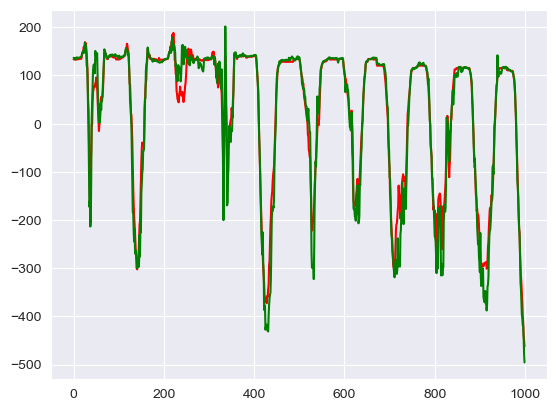

In [439]:
plt.plot(read_submission.residual_load.values[0:1000],'r')
plt.plot(residual_load_test[0:1000],'g')

#plt.plot(sample_submission.residual_load.values)


In [436]:
sample_submission.residual_load = residual_load_test
sample_submission.head()
# sample_submission.to_csv('first_submission_amburgerh.csv', index=False)
# sample_submission.to_csv('second_submission_amburgerh.csv', index=False) # mixed models + small hyper Par tuning
sample_submission.to_csv('third_submission_amburgerh.csv', index=False) # 11 P models


7392

In [301]:
# read_submission = pd.read_csv('first_submission_amburgerh.csv')
read_submission = pd.read_csv('second_submission_amburgerh.csv')
read_submission.head()

len(read_submission)

,time,residual_load
0,2018-03-26 00:00:00,133.442993
1,2018-03-26 00:15:00,133.442993
2,2018-03-26 00:30:00,133.442993
3,2018-03-26 00:45:00,133.442993
4,2018-03-26 01:00:00,133.442993


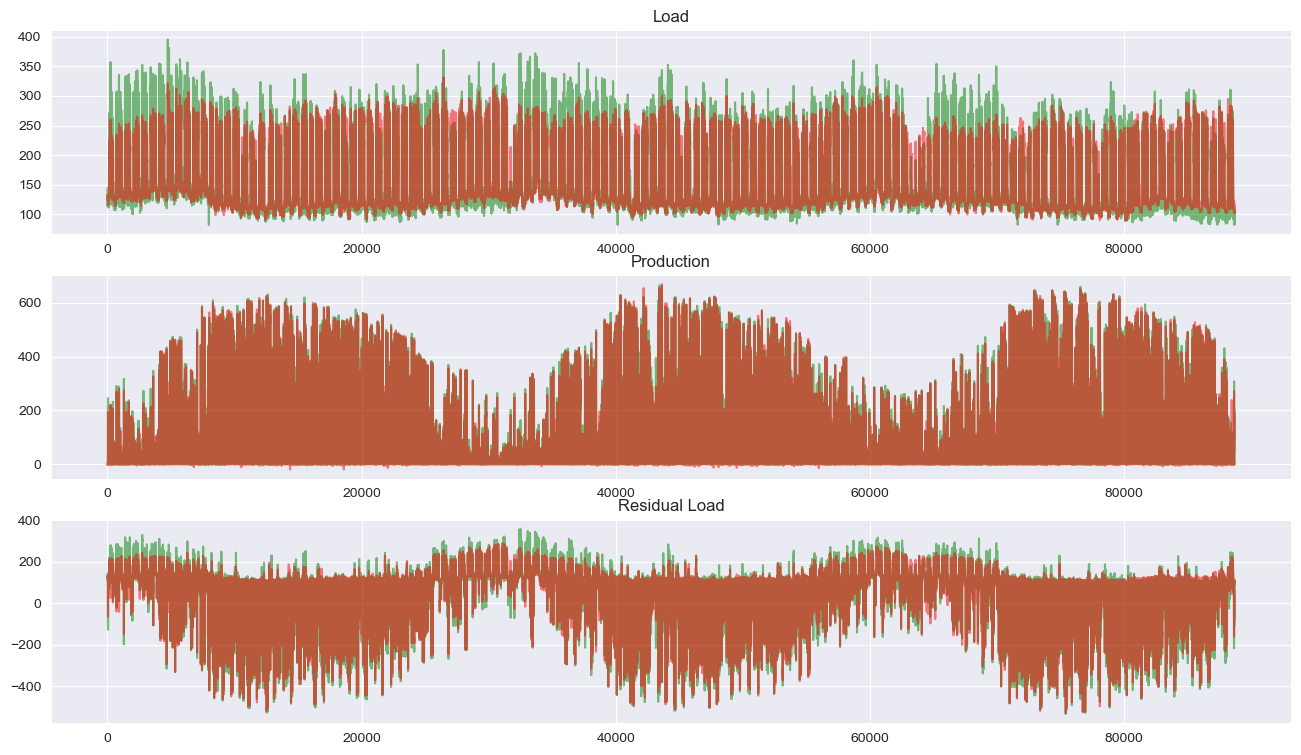

In [432]:
plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
plt.plot(train.load.values,'g',alpha=0.5)
plt.plot(predicted_load_train,'r',alpha=0.5)
plt.title('Load')

plt.subplot(3,1,2)
plt.plot(train.P.values,'g',alpha=0.5)
plt.plot(predicted_P_train,'r',alpha=0.5)
plt.title('Production')

plt.subplot(3,1,3)
plt.plot(train.residual_load.values,'g',alpha=0.5)
plt.plot(residual_load_train,'r',alpha=0.5)
plt.title('Residual Load')
plt.savefig('figs/load_production_residual_load_forecast.png')


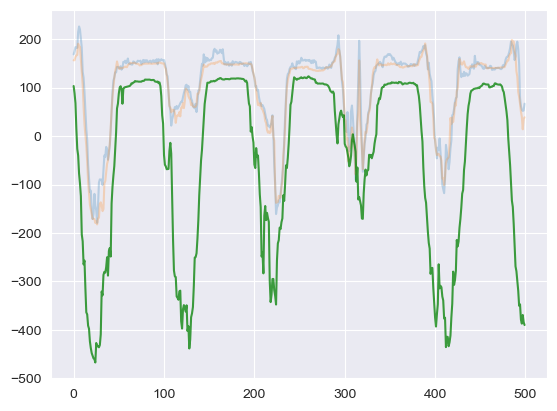

In [435]:
## SOME EXAMPLES
window = 500
index = np.random.randint(len(residual_load_test))
#
plt.plot(train.residual_load.values[index:index+window],alpha=0.25)
plt.plot(residual_load_train[index:index+window],alpha=0.25)
plt.plot(residual_load_test[index:index+window],color='green', alpha=0.75)


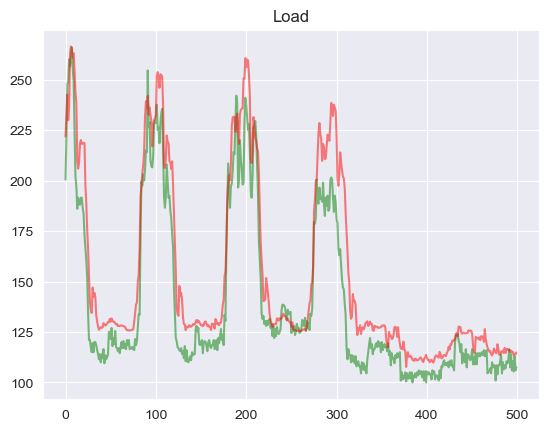

In [365]:
## Look at an example
window = 500
index = np.random.randint(len(predicted_load_train))

plt.plot(train.load.values[index:index+window],'g',alpha=0.5)
plt.plot(predicted_load_train[index:index+window],'r',alpha=0.5)
plt.title('Load')

plt.savefig('figs/load_forecast_example.png')

Text(0.5, 1.0, 'Residual Load')

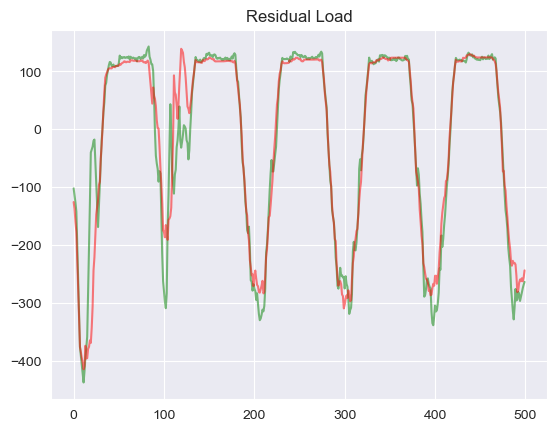

In [412]:
## Look at an example
window = 500
index = np.random.randint(len(residual_load_train))

plt.plot(train.residual_load.values[index:index+window],'g',alpha=0.5)
plt.plot(residual_load_train[index:index+window],'r',alpha=0.5)
plt.title('Residual Load')

#plt.savefig('figs/Residual_load_forecast_example.png')

# OLD STUFF

In [ ]:
# How to get that?
# improved generation forecast by cloud coverage?
# Answer Moritz, Post about Status
# Continue on the Paper front


In [155]:
# i = 1 # until length of df
# avg_model = []
# std_model = []
#
# for i in range(len(train)):
#     # if (np.unique(train.public_holidays[i])==1) or (np.unique(train.weekday[i])==0):
#     #     use_index = hourInddict[train.index[i].hour][train.index[i].minute]
#     #
#     #     avg_model.append(otherModel_avg[use_index])
#     #     std_model.append(otherModel_std[use_index])
#     else:
#         use_index = hourInddict[train.index[i].hour][train.index[i].minute]
#
#         avg_model.append(weekDayModel_avg[use_index])
#         std_model.append(weekDayModel_std[use_index])
#
# len(avg_model)

88712

In [188]:
# ## FIRST GET THE AVERAGE CURVE FOR WEEKDAYS AND OTHER DAYS
# def get_avg_day_load(df):
#     # average weekend curve
#     # average week curve
#
#     # reshape it into days and
#     dayShapedLoad = np.reshape(df.load.values[:88704],(-1,96))
#     dayShapedWeekday = np.reshape(df.weekday.values[:88704],(-1,96))
#     dayShapedHoliday = np.reshape(df.public_holidays.values[:88704],(-1,96))
#
#
#     weekDayLoad = np.empty((1,96))
#     otherDayLoad = np.empty((1,96))
#
#     for i in range(0,len(dayShapedLoad)):
# #         if (np.unique(dayShapedHoliday[i])==1) or (np.unique(dayShapedWeekday[i])==0):
#         if (round(np.mean(dayShapedHoliday[i]))==1) or (round(np.mean(dayShapedWeekday[i]))==0):
# #            print('holiday or weekend')
#             otherDayLoad = np.vstack((otherDayLoad,np.reshape(dayShape[i],(1,96))))
#         else:
#             weekDayLoad = np.vstack((weekDayLoad,np.reshape(dayShape[i],(1,96))))
#
#     weekDayLoad = weekDayLoad[1:]
#     otherDayLoad = otherDayLoad[1:]
#
#     weekDayModel_avg  = np.mean(weekDayLoad,axis=0)
#     weekDayModel_std  = np.std(weekDayLoad,axis=0)
#
#     otherModel_avg  = np.mean(otherDayLoad,axis=0)
#     otherModel_std  = np.std(otherDayLoad,axis=0)
#
#
#     return weekDayModel_avg, weekDayModel_std, otherModel_avg, otherModel_std
#
# ## THEN GENERATE A VECTOR FROM TIME INDEX
# def generate_avg_model(df,weekModel_avg,otherModel_avg, weekModel_std,otherModel_std,hourInddict):
#
#     avg_model = []
#     std_model = []
#
#     for i in range(len(df)):
#         if (np.unique(df.public_holidays[i])==1) or (np.unique(df.weekday[i])==0):
#             use_index = hourInddict[df.index[i].hour][df.index[i].minute]
#
#             avg_model.append(otherModel_avg[use_index])
#             std_model.append(otherModel_std[use_index])
#         else:
#             use_index = hourInddict[df.index[i].hour][df.index[i].minute]
#
#             avg_model.append(weekDayModel_avg[use_index])
#             std_model.append(weekDayModel_std[use_index])
#
#     return avg_model, std_model
#
#
# ## STEP 1
# weekDayModel_avg, weekDayModel_std, otherModel_avg, otherModel_std = get_avg_day_load(train)
#
#
# ## STEP 2
# ## first create the dict within dict
# hourInddict = dict()
# for ind in range(96):
#
#     hourInddict[train.index[ind].hour] = dict()
#
# # then fill it with the 96 values
# for ind in range(96):
#     hourInddict[train.index[ind].hour][train.index[ind].minute] = ind
#
# avg_model_train, std_model = generate_avg_model(train,weekDayModel_avg,otherModel_avg, weekDayModel_std,otherModel_std, hourInddict)
# avg_model_test, std_model = generate_avg_model(test,weekDayModel_avg,otherModel_avg, weekDayModel_std,otherModel_std, hourInddict)
#
# ####
#
# ## ADD TO TRAIN AND TEST
# train['avg_load_model'] = avg_model_train
# test['avg_load_model'] = avg_model_test
#
# plt.plot(avg_model_train[0:800], alpha=0.2)
#
# train.head()

In [133]:
# # reshape it into days and
# dayShapedLoad = np.reshape(train.load.values[:88704],(-1,96))
# dayShapedWeekday = np.reshape(train.weekday.values[:88704],(-1,96))
# dayShapedHoliday = np.reshape(train.public_holidays.values[:88704],(-1,96))
#
# weekDayLoad = np.empty((1,96))
# otherDayLoad = np.empty((1,96))
#
# for i in range(0,len(dayShapedLoad)):
# #    plt.plot(dayShapedLoad[i], alpha=0.3)
#
#     if (np.unique(dayShapedHoliday[i])==1) or (np.unique(dayShapedWeekday[i])==0):
# #        print('holiday or weekend')
#         otherDayLoad = np.vstack((otherDayLoad,np.reshape(dayShape[i],(1,96))))
#     else:
#         weekDayLoad = np.vstack((weekDayLoad,np.reshape(dayShape[i],(1,96))))
#
# weekDayLoad = weekDayLoad[1:]
# otherDayLoad = otherDayLoad[1:]
#
# weekDayModel_avg  = np.mean(weekDayLoad,axis=0)
# weekDayModel_std  = np.std(weekDayLoad,axis=0)
#
# otherModel_avg  = np.mean(otherDayLoad,axis=0)
# otherModel_std  = np.std(otherDayLoad,axis=0)


holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or weekend
holiday or w

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

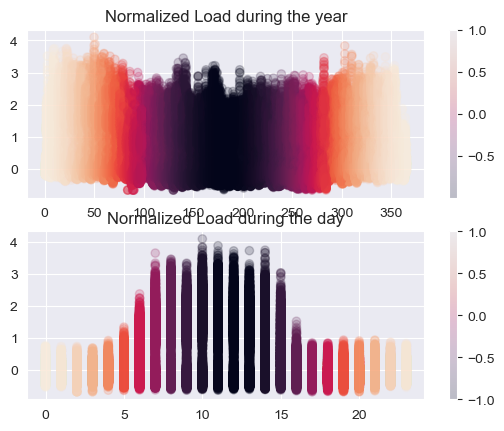

In [393]:
plt.subplot(2,1,1)
plt.scatter(doy,train.normalized_load,c=train.dayOfYearSinosoid,alpha=0.2)
plt.title('Normalized Load during the year')
plt.colorbar()
plt.subplot(2,1,2)
plt.scatter(train.hour,train.normalized_load,c=train.hourSinosoid,alpha=0.2)
plt.title('Normalized Load during the day')
plt.colorbar()

plt.savefig('figs/load_analysis.png')



In [ ]:
## Separated into two sets for prediction
# train_part1 = train.loc[(train['dataset_id'] == 1) | (train['dataset_id'] == 2 ) | (train['dataset_id'] == 5 ) \
#                         | (train['dataset_id'] == 6 ) | (train['dataset_id'] == 9 ) | (train['dataset_id'] == 10 )]
# train_part2 = train.loc[(train['dataset_id'] == 3) | (train['dataset_id'] == 4 ) | (train['dataset_id'] == 7 ) \
#                         | (train['dataset_id'] == 8 ) | (train['dataset_id'] == 11 )]


In [248]:
## THIS WAS NOT SUCCESSFULL
# group them efficiently
# first with overlap for the dataset id ->1 means use model 1_2
# a) 1-2 can be grouped with 5-6: month 1-7
# b) 2-3 can be grouped with 6-7: month 4-10
# c) 3-4 can be grouped with 7-8: month 7-1

# 9-10 can be grouped with a) 1-7
# 10 can be grouped with b) 4-10

# group_data_sets ={'a' : [1,2,5,6,9,10],
#                  'b': [3,4,7,8,11]}


# SPLIT THE DATA SET INTO TWO PIECES FOR SAME TIME DURING THE YEAR -> Result was worse
# train_part1 = train.loc[(train['dataset_id'] == 1) | (train['dataset_id'] == 2 ) | (train['dataset_id'] == 5 ) \
#                         | (train['dataset_id'] == 6 ) | (train['dataset_id'] == 9 ) | (train['dataset_id'] == 10 )]
# train_part2 = train.loc[(train['dataset_id'] == 3) | (train['dataset_id'] == 4 ) | (train['dataset_id'] == 7 ) \
#                         | (train['dataset_id'] == 8 ) | (train['dataset_id'] == 11 )]
# print(len(train_part1))
# print(len(train_part2))
#
# plt.subplot(1,2,1)
# plt.scatter(train_part1.index,train_part1.residual_load)
#
# plt.subplot(1,2,2)
# plt.scatter(train_part2.index,train_part2.residual_load)


11

# just do a forecast of target for all at the same time

In [422]:
reg_model, X_train, X_test, y_train, y_test = train_a_gbrt_model(train,features,target)

reg_model.predict(X_test)

print(reg_model.score(X_test, y_test))

# a global model is worse than 10 individual!

0.8277538951524619


In [ ]:
# save gbrt models for Production and Consumption
# predict full train  for both
# calculate residual load

# compare with score from E2E model

# CHOSE the "best" and make a prediction on the "Test" set
# EXCHANGE THE REGRESSOR?
# HYPERPARAMETER TUNING?
# submit to Kaggle, see the score


In [534]:
# for isel in uniqueIds[:-1]:
#
#     train_part = train.loc[(train['dataset_id'] == 1) & (train['dataset_id'] == 2 ) & (train['dataset_id'] == 3 )]
#     print('dataset_id',isel)
#     print(train_part.index[0].month)
#     print(train_part.index[-1].month)
# #    len(train_part)
#     print(train_part['dataset_id'].value_counts())

In [406]:
# score (met Only) = 0.8193671855763222
# score (met + timeVars) = 0.8318759060928897

# reg.predict(X_train)
# reg.score(X_test, y_test)

# met only: The mean squared error (MSE) on test set: 0.3211
# met + time Vars: The mean squared error (MSE) on test set: 0.2989

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1357.1810


In [ ]:
# nMSE at 0.321 - simple BENCHMARK
# add day, month, time features
# extended benchmark check
#
# then start with multiple model regression
# either combination of dataset ids
# train 11 models? adjacent datasets
#
# if dataset_id = 2 -> use trained_model_1_2, only if its a dataset_id=10 -> use trained_model_10_1
# smart combination of multiple models
# you could also combine Summer models & winter models ->
#
#
# or by first classification of "mode", day and night?
# -> cluster analysis
#
# WE NEED A GOOD TOOL TO CALCULATE THE WEIGHTED AVERAGE SCORE
#
# Put this all together and clean up
# Submit a Prediction!
#